In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import os
import cv2
import time

from scipy.spatial import cKDTree
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


In [3]:
# segment-anything-2 functions
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [4]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

/home/wsl/bin/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [73]:
# wing = cv2.imread("/mnt/c/Projects/Master/Data/WingScanCrops/Hive01_Sheet_01/Hive01_Sheet_01_Label_1_Left.jpg")
wing = cv2.imread("/mnt/c/Projects/Master/Data/WingScanCrops/Hive01_Sheet_01/Hive01_Sheet_01_Label_50_Left.jpg")

In [83]:
def remove_background(wing):
    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(wing, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    expanded_image = cv2.copyMakeBorder(wing, 1000, 1000, 1000, 1000, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(expanded_image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to get a binary image
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    # Invert the binary image
    inv_thresh = cv2.bitwise_not(thresh)
    
    # Show image
    # plt.figure(figsize=(5, 5))
    # plt.imshow(inv_thresh, cmap="gray")
    # plt.axis('off')
    # plt.show()
    
    # Find contour
    contours, _ = cv2.findContours(inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5000]
    contour = large_contours[0]
    
    # Draw contours on the image for visualization
    wing_contour_image = expanded_image.copy()
    cv2.drawContours(wing_contour_image, large_contours, -1, (0, 0, 255), 5)
    
    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(wing_contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Find centroid
    M = cv2.moments(contour)
    if not M['m00'] != 0:
        print("No centroid found!")
        exit()
        
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    point = np.array([[cx, cy]])
    label = np.array([1] * len(point))
    
    # Sam background removal
    predictor.set_image(expanded_image)
    
    mask, scores, _ = predictor.predict(
        point_coords=point,
        point_labels=label,
        multimask_output=False,
    )
    sorted_ind = np.argsort(scores)[::-1]
    mask = mask[sorted_ind]
    score = scores[sorted_ind]
    
    # show_masks(expanded_image, masks, scores, point_coords=point, input_labels=label, borders=True)
    
    # Remove extra dimension
    mask = mask.squeeze()
    
    # Create a white image of the same size as the original image
    white_image = np.ones_like(expanded_image) * 255
    
    # Apply the mask to each channel (no extra dimension added)
    wing_image = np.where(mask[:, :, None], expanded_image, white_image)
    
    # Show image
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(wing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return wing_image


In [75]:
def crop_wing(wing_image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(wing_image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to get a binary image
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    # Invert the binary image
    inv_thresh = cv2.bitwise_not(thresh)
    
    # Show image
    # plt.figure(figsize=(5, 5))
    # plt.imshow(inv_thresh, cmap="gray")
    # plt.axis('off')
    # plt.show()
    
    # Find contour
    contours, _ = cv2.findContours(inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5000]
    contour = large_contours[0]
    
    # Draw contours on the image for visualization
    wing_contour_image = wing_image.copy()
    cv2.drawContours(wing_contour_image, large_contours, -1, (0, 0, 255), 5)
    
    # Show image
    # plt.figure(figsize=(5, 5))
    # plt.imshow(cv2.cvtColor(wing_contour_image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    
    # Get the minimum area rectangle
    rect = cv2.minAreaRect(contour)
    
    # Get the four points of the rectangle
    box = cv2.boxPoints(rect)
    
    # Convert the points to integers
    box = np.int0(box)
    
    # Draw the rotated rectangle
    contour_image = wing_image.copy()
    cv2.drawContours(contour_image, [box], 0, (0, 0, 255), 5)
    
    # Get the rectangle's center, size (width, height), and angle
    box_center, box_size, angle = rect
    
    # Ensure width is the longest side (width > height)
    width, height = box_size
    if height > width:
        width, height = height, width
        angle -= 90  # Rotate to make the longest side horizontal
    
    # Get the rotation matrix to rotate the image around the rectangle's center
    rotation_matrix = cv2.getRotationMatrix2D(box_center, angle, 1.0)
    
    # Rotate the entire image
    rotated_image = cv2.warpAffine(wing_image, rotation_matrix, (wing_image.shape[1], wing_image.shape[0]))
    
    # Convert the center and size to integers
    box_center = (int(box_center[0]), int(box_center[1]))
    width, height = int(width), int(height)
    
    # Crop the aligned rectangle from the rotated image
    cropped_image = cv2.getRectSubPix(rotated_image, (width+20, height+20), box_center)
    
    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('on')
    plt.show()

    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('on')
    plt.show()
    
    return(cropped_image)

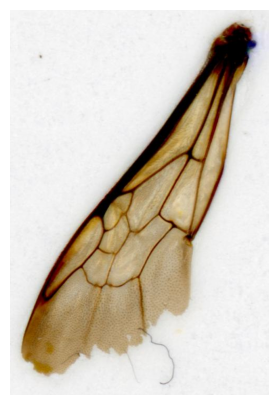

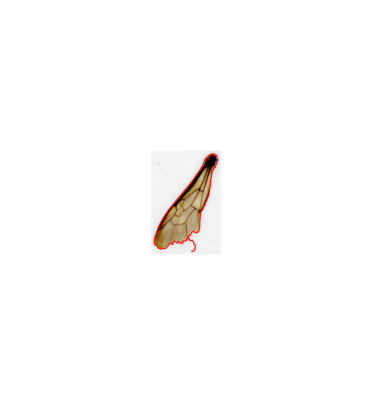

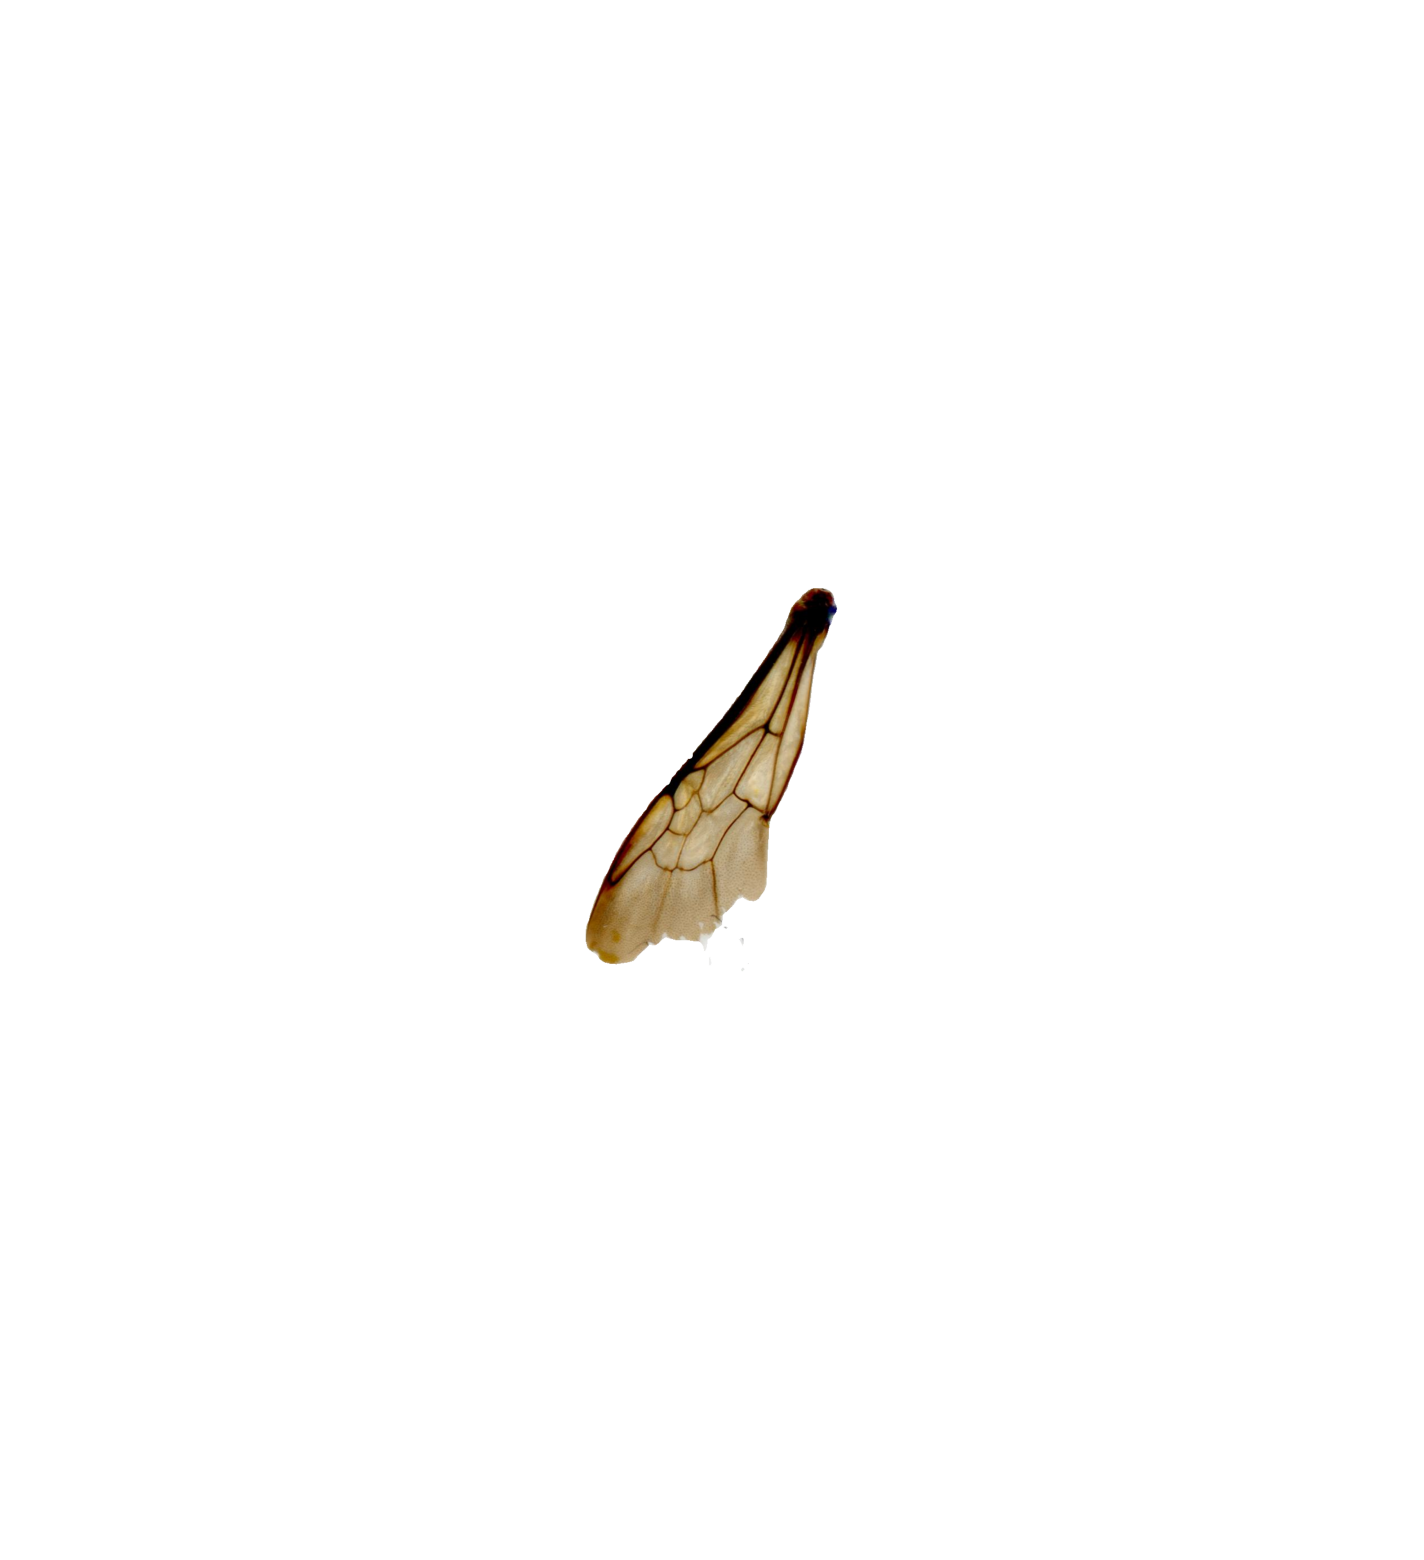

In [76]:
wing = remove_background(wing)

/tmp/ipykernel_29407/1583816953.py:39: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


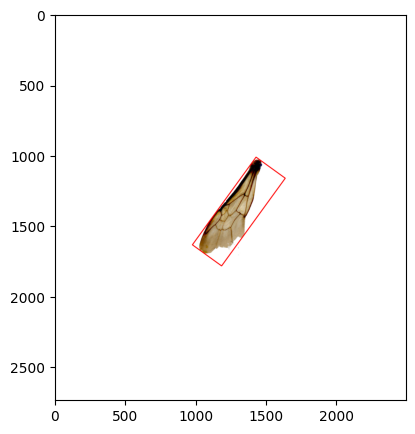

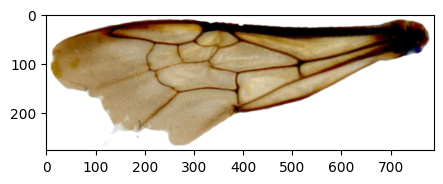

In [77]:
wing = crop_wing(wing)

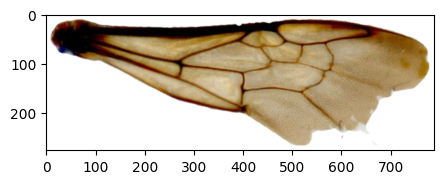

In [79]:
cropped_image = wing
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
cropped_image = Image.fromarray(cropped_image)
cropped_image = cropped_image.transpose(method=Image.FLIP_LEFT_RIGHT)

# Show image
plt.figure(figsize=(5, 5))
plt.imshow(cropped_image)
plt.axis('on')
plt.show()

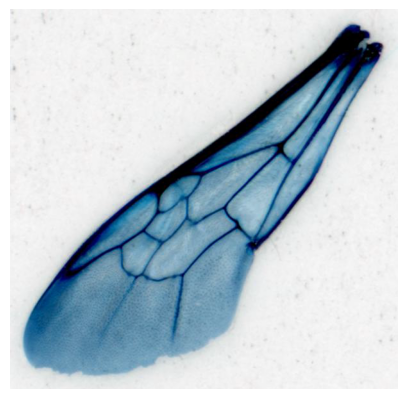

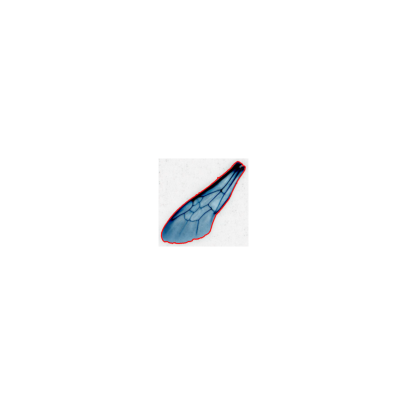

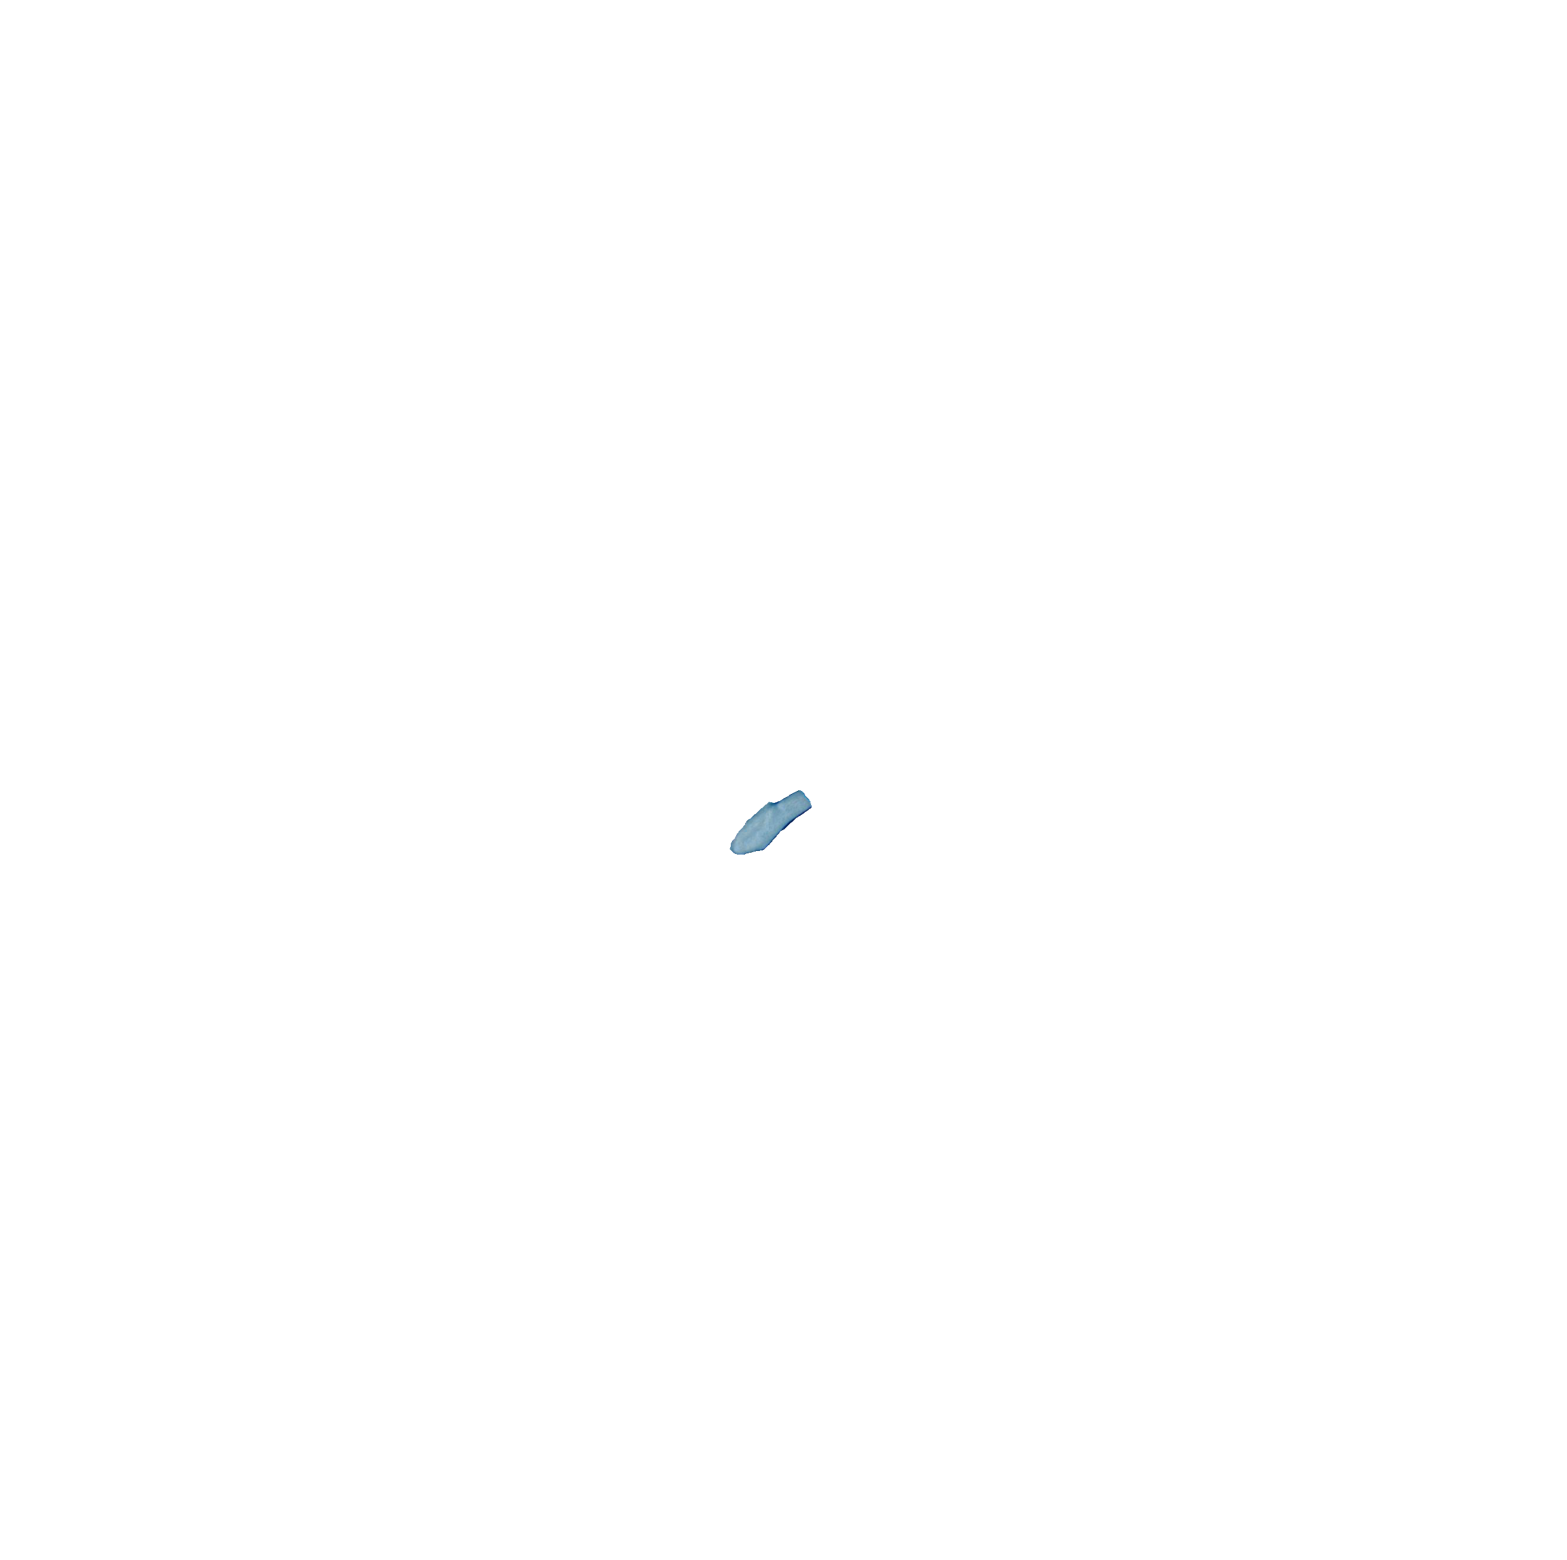

/tmp/ipykernel_29407/1583816953.py:39: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


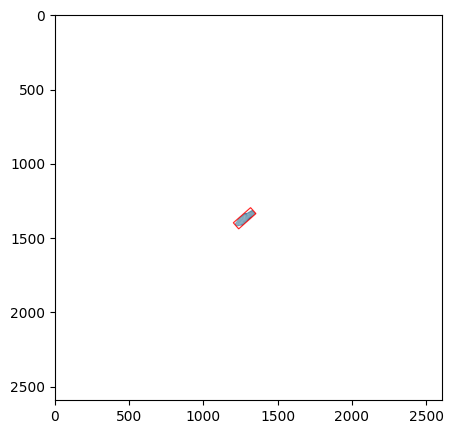

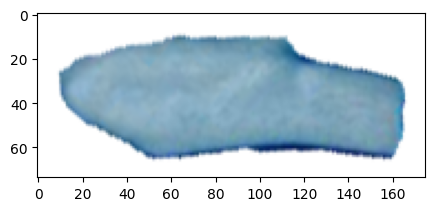

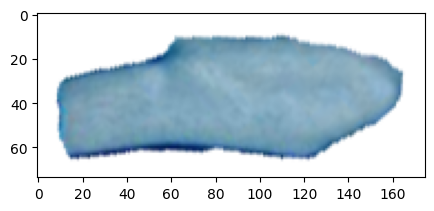

In [82]:
input_dir = "/mnt/c/Projects/Master/Data/WingScanCrops/Hive01_Sheet_01/"
output_dir = "/mnt/c/Projects/Master/Data/Segmented/Hive01_Sheet_01/"

# Ensure the input directory exists
if not os.path.exists(input_dir):
    raise FileNotFoundError(f"Input directory '{input_dir}' was not found.")

# Create the output directory
os.makedirs(output_dir, exist_ok=True)

# Find jpg files
jpg_files = [file for file in os.listdir(input_dir) if file.endswith('.jpg')]

# Loop through all scans
for i, filename in enumerate(jpg_files):
    if filename != "Hive01_Sheet_01_Label_1_Left.jpg":
        # pass
        continue
    input_file = input_dir + filename
    wing = Image.open(input_file)
    wing = np.array(wing.convert("RGB"))
    wing = remove_background(wing)
    cropped_image = crop_wing(wing)
    
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    cropped_image = Image.fromarray(cropped_image)
    if "Left" in filename:
        cropped_image = cropped_image.transpose(method=Image.FLIP_LEFT_RIGHT)

    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image)
    plt.axis('on')
    plt.show()